# Action1_LSTM_(60,1)_meijimu_stock

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [165]:
meijimu = pd.read_csv('./002621.csv')  # 读取股票文件
meijimu[::-1]

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
2195,2011/9/29,'002621,N三垒,24.08,25.15,22.88,23.98,24.00,0.08,0.3333,57.5282,11522900,2.806628e+08,2408000000,482322400
2194,2011/9/30,'002621,大连三垒,22.69,23.80,22.05,23.10,24.08,-1.39,-5.7724,26.7312,5354251,1.215095e+08,2269000000,454480700
2193,2011/10/10,'002621,大连三垒,23.60,24.18,22.36,22.66,22.69,0.91,4.0106,22.7764,4562109,1.065325e+08,2360000000,472708000
2192,2011/10/11,'002621,大连三垒,24.13,25.85,23.70,24.25,23.60,0.53,2.2458,34.9752,7005537,1.723708e+08,2413000000,483323900
2191,2011/10/12,'002621,大连三垒,24.80,25.15,22.55,23.60,24.13,0.67,2.7766,30.1920,6047448,1.458584e+08,2480000000,496744000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020/10/12,'002621,美吉姆,6.96,6.99,6.72,6.99,6.86,0.1,1.4577,0.5032,4071930,2.812961e+07,5753573554,5632501229
3,2020/10/13,'002621,美吉姆,6.95,6.96,6.84,6.95,6.96,-0.01,-0.1437,0.2279,1844460,1.275408e+07,5745306926,5624408555
2,2020/10/14,'002621,美吉姆,6.85,7.16,6.84,6.93,6.95,-0.1,-1.4388,0.4038,3267859,2.279647e+07,5662640639,5543481813
1,2020/10/15,'002621,美吉姆,7.04,7.23,6.90,7.02,6.85,0.19,2.7737,0.7743,6265798,4.435304e+07,5819706584,5697242623


In [166]:
# meijimu = meijimu[::-1]
meijimu.iloc[0]

日期        2011/9/29
股票代码        '002621
名称              N三垒
收盘价           24.08
最高价           25.15
最低价           22.88
开盘价           23.98
前收盘              24
涨跌额            0.08
涨跌幅          0.3333
换手率         57.5282
成交量        11522900
成交金额    2.80663e+08
总市值      2408000000
流通市值      482322400
Name: 2195, dtype: object

In [167]:
train_set = meijimu.iloc[0:2196 - 300, 6:7].values  # 前(2196-300=1896)天的开盘价作为训练集,表格从0开始计数，6:7是提取[6:7)列，前闭后开,故提取出开盘价
test_set = meijimu.iloc[2196 - 300:, 6:7].values  # 后300天也就是最近的300天的开盘价作为测试集

In [168]:
train_set.shape,test_set.shape

((1896, 1), (300, 1))

In [169]:
# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
train_set_scaled = sc.fit_transform(train_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

In [170]:
x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2196-300=1896天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2196-300-60=1836组数据。
for i in range(60, len(train_set_scaled)):
    x_train.append(train_set_scaled[i - 60:i, 0]) # 1836
    y_train.append(train_set_scaled[i, 0]) # 1836

In [173]:
y_train[-1]

0.38624019312009655

In [10]:
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [11]:
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
x_train

array([[0.53651177, 0.51297526, 0.52082076, ..., 0.52172601, 0.51297526,
        0.51991551],
       [0.38322269, 0.38624019, 0.38925769, ..., 0.39921545, 0.38774894,
        0.37718769],
       [0.75709113, 0.70911285, 0.69764635, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4097767 , 0.41128546, 0.42607121, ..., 0.46167773, 0.47163549,
        0.46710923],
       [0.65479783, 0.64182257, 0.62854556, ..., 0.84791792, 0.86541943,
        0.85485818],
       [0.4073627 , 0.3983102 , 0.40102595, ..., 0.35304768, 0.3922752 ,
        0.3940857 ]])

In [13]:
x_train.shape

(1836, 60)

In [14]:
# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即1836组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
x_train.shape

(1836, 60, 1)

In [15]:
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [16]:
# 构建LSTM模型
model = tf.keras.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

In [17]:
# 配置优化器，损失函数
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

In [18]:
# 设置checkpoint配置路径
checkpoint_save_path = "./checkpoint/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

In [19]:
# 回调函数，保存最优模型
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

In [27]:
# 模型训练拟合
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

Epoch 1/10
29/29 [==============================] - 4s 130ms/step - loss: 0.0100 - val_loss: 6.9348e-04
Epoch 2/10
29/29 [==============================] - 4s 134ms/step - loss: 0.0094 - val_loss: 3.6851e-04
Epoch 3/10
29/29 [==============================] - 3s 116ms/step - loss: 0.0087 - val_loss: 3.1641e-04
Epoch 4/10
29/29 [==============================] - 4s 138ms/step - loss: 0.0086 - val_loss: 7.1571e-04
Epoch 5/10
29/29 [==============================] - 4s 139ms/step - loss: 0.0079 - val_loss: 6.4727e-04
Epoch 6/10
29/29 [==============================] - 4s 142ms/step - loss: 0.0083 - val_loss: 2.8164e-04
Epoch 7/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0077 - val_loss: 4.9133e-04
Epoch 8/10
29/29 [==============================] - 3s 106ms/step - loss: 0.0076 - val_loss: 2.1031e-04
Epoch 9/10
29/29 [==============================] - 3s 117ms/step - loss: 0.0073 - val_loss: 2.2210e-04
Epoch 10/10
29/29 [==============================] - 3s 115ms/st

In [28]:
# 模型参数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 80)            26240     
_________________________________________________________________
dropout (Dropout)            (None, 60, 80)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               72400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 98,741
Trainable params: 98,741
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 查看训练过程中梯度下降更新的weights和bias
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

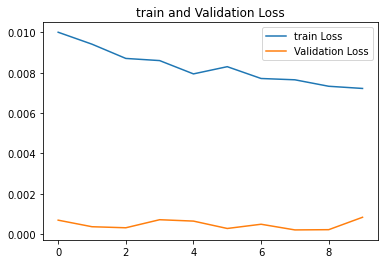

In [30]:
# 绘图训练loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('train and Validation Loss')
plt.legend()
plt.show()

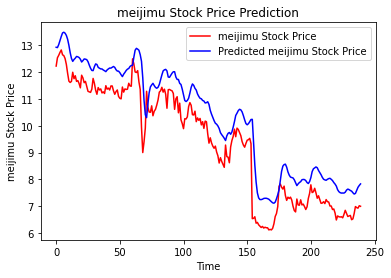

In [31]:
################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='meijimu Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted meijimu Stock Price')
plt.title('meijimu Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('meijimu Stock Price')
plt.legend()
plt.show()

In [32]:
real_stock_price.shape

(240, 1)

In [33]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.919053
均方根误差: 0.958673
平均绝对误差: 0.875848


<font color=red size=6>模型预测探索-失败，预测不能用预测数据作为测试集。。</font>

<font color=red size=6>要考虑在输入、输出时间步长上处理这个问题</font>

In [158]:
x_predict = list(y_test[-60:])

In [159]:
y_predict = list()

In [160]:
# 预测未来30天，将每60时序预测的值作为新的60时序的结尾值，输入模型进行预测
for i in range(30):
    temp_predict = model.predict(np.reshape(np.array(x_predict),(1,60,1)))[0][0]
    y_predict.append(temp_predict)
    x_predict.append(temp_predict)
    x_predict = x_predict[1:]

In [161]:
y_forecast = np.reshape(np.array(y_predict),(len(y_predict),1))
y_forecast = sc.inverse_transform(y_forecast) # 反转归一化
y_forecast = np.concatenate((predicted_stock_price,y_forecast))

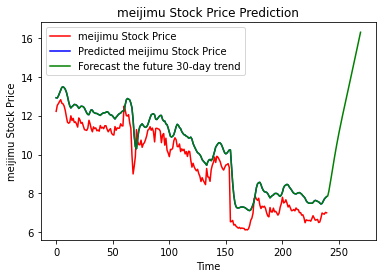

In [163]:
plt.plot(real_stock_price, color='red', label='meijimu Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted meijimu Stock Price')
plt.plot(y_forecast, color='green', label='Forecast the future 30-day trend')
plt.title('meijimu Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('meijimu Stock Price')
plt.legend()
plt.show()=